**#Proof-of-concept synthesis**

In [1]:
# Install latest version of the ORKG R package from Git
install.packages('remotes')
remotes::install_gitlab("TIBHannover/orkg/orkg-r", force=TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

from URL https://gitlab.com/api/v4/projects/38478922/repository/archive.tar.gz?sha=HEAD




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpXmNBJH/remotes6831e484ed0/orkg-r-HEAD-4296570ae50cde50c6e69c382b40adf54a61129d/DESCRIPTION’ ... OK
* preparing ‘orkg’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘orkg_0.1.0.tar.gz’



In [2]:
# Connect with ORKG
library(orkg)
orkg <- ORKG(host='https://incubating.orkg.org/')

Loading required package: stringr

Loading required package: glue

Loading required package: jsonlite

Loading required package: sets


Attaching package: ‘sets’


The following object is masked from ‘package:stringr’:

    %>%


Loading required package: hash

hash-2.2.6.2 provided by Decision Patterns




In [3]:
#retrieve significance testing output dataset for Ricardo's fig. 4a (aphid incidence) (n=42) - here we want the p-value (need to run this code to create my test dataframe and Ricardo's dataframe, which is the one we will actually use for the meta-analysis)
PerezAlvarez2018Fig4aSigTest <- orkg$resources$by_id('R569582')$as_dataframe()
PerezAlvarez2018Fig4aSigTest 
#retrieve significance testing output dataset for Ricardo's fig. 4b (flea beetle abundance) (n=43) - here we want the p-value
PerezAlvarez2018Fig4bSigTest <- orkg$resources$by_id('R570502')$as_dataframe()
PerezAlvarez2018Fig4bSigTest
#retrieve significance testing output dataset for Ricardo's fig. 4c (incidence of lepidopteran larvae) (n=41) - here we want the p-value
PerezAlvarez2018Fig4cSigTest <- orkg$resources$by_id('R571405')$as_dataframe()
PerezAlvarez2018Fig4cSigTest
#retrieve ANOVA output dataset for Daniel's fig. 4 (Bactrocera oleae abundance) (n=25) - here we want the Pr..Chi value
Paredes2022Fig4Anova <- orkg$resources$by_id('R552440')$as_dataframe()
Paredes2022Fig4Anova

,p-value,t-value,DF,Std.Error,Value
,<chr>,<chr>,<chr>,<chr>,<chr>
(Intercept),0.5768,0.5668,21,0.0791,0.0449
mead_250,0.0054,3.1029,21,0.1866,0.5791
Year2015,0,5.5384,21,0.0582,0.3225


,p-value,t-value,DF,Std.Error,Value
,<chr>,<chr>,<chr>,<chr>,<chr>
(Intercept),0.3292,0.9979,22,1.1789,1.1764
mead_250,0.0068,2.9875,22,2.7625,8.2527
Year2015,0.5346,-0.6309,22,0.8694,-0.5485


,p-value,t-value,DF,Std.Error,Value
,<chr>,<chr>,<chr>,<chr>,<chr>
(Intercept),0,5.6991,21,0.0736,0.4192
mead_1000,0.0361,-2.2387,21,0.2047,-0.4582
Year2015,3.1207e-06,6.2842,21,0.0425,0.2669


,Pr..Chi.,Resid..Dev,Resid..Df,Deviance,Df
,<chr>,<chr>,<chr>,<chr>,<chr>
NULL,NA,31.8955,24,NA,NA
shdi,0.035,27.4522,23,4.4433,1


In [15]:
#####CREATING A JOIN DATASET #############################

#create and merge dataframes
Perez_Fig4a<- as.data.frame(PerezAlvarez2018Fig4aSigTest)
species_Fig4a <- c("aphids", "aphids", "aphids")
Perez_Fig4a["species"] <- species_Fig4a 

Perez_Fig4b<- as.data.frame(PerezAlvarez2018Fig4bSigTest)
species_Fig4b <- c("flea beetles", "flea beetles", "flea beetles")
Perez_Fig4b["species"] <- species_Fig4b 

Perez_Fig4c<- as.data.frame(PerezAlvarez2018Fig4cSigTest)
species_Fig4c <- c("Lepidoptera", "Lepidoptera", "Lepidoptera")
Perez_Fig4c["species"] <- species_Fig4c

Perez_Fig4_Total <-rbind(Perez_Fig4a, Perez_Fig4b,Perez_Fig4c)
#remove unnecessary rows from dataframe
Perez_Fig4_Total2 <-Perez_Fig4_Total[-c(1,3, 4, 6,7,9), ]  
#add  column with direction (for the correlation)
direction_perez <- c(1, 1, -1)
Perez_Fig4_Total2["Direction"] <- direction_perez
#making sure row names are accurate
rownames(Perez_Fig4_Total2) <- c("mead_250","mead_250 (2)","mead_1000")
#add column to the entire dataframe, so we could merge this with other dataframes
study_perez <- c("Perez-Alvarez2018", "Perez-Alvarez2018", "Perez-Alvarez2018")
Perez_Fig4_Total2["Study"] <- study_perez
# removing unnecesary columns from the dataframe
names(Perez_Fig4_Total2)
Perez_total = subset(Perez_Fig4_Total2, select = -c(DF,Std.Error,Value))
#add column with type of test and sample size
stats_test_perez <- c("t-value", "t-value", "t-value")
SampleSize_perez <- c(42, 43, 41)
Perez_total["stats_test"] <- stats_test_perez
Perez_total["Sample size"] <- SampleSize_perez 

#change column names
colnames(Perez_total ) <- c('p.value','Statistic.value','species',"Direction", "Study", "stats_test_Type","Sample_size")

#Now we are going to merge Perez_total with the dataframe from Paredes study
#select relevant columns from Paredes
#names (Paredes2022Fig4Anova)

Paredes_total = subset(Paredes2022Fig4Anova, select = c(Pr..Chi.))
colnames(Paredes_total) <- c('p-value')
#Paredes_total

#create dataframe from paredes with the same column names than Perez_total
Paredes_full<- data.frame (
  p.value = 0.035,
  Statistic.value = NA,
  species= "Bactrocera oleae", 
  Direction= -1, 
  Study= "Paredes2022",
  stats_test_Type="chisqquared",
  Sample_size= 25)
#change row name
rownames(Paredes_full) <- c("shdi")

#Join Perez and paredes
MetaAnalysis_Data <-rbind(Perez_total, Paredes_full)

#This is the final dataframe that include all data
MetaAnalysis_Data

[1] "p-value"   "t-value"   "DF"        "Std.Error" "Value"     "species"  
[7] "Direction" "Study"

[1] "Pr..Chi."   "Resid..Dev" "Resid..Df"  "Deviance"   "Df"

,p-value
,<chr>
NULL,NA
shdi,0.035


,p.value,Statistic.value,species,Direction,Study,stats_test_Type,Sample_size
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
mead_250,0.0054,3.1029,aphids,1,Perez-Alvarez2018,t-value,42
mead_250 (2),0.0068,2.9875,flea beetles,1,Perez-Alvarez2018,t-value,43
mead_1000,0.0361,-2.2387,Lepidoptera,-1,Perez-Alvarez2018,t-value,41
shdi,0.035,NA,Bactrocera oleae,-1,Paredes2022,chisqquared,25


In [13]:
install.packages('meta')
install.packages('esc')
install.paclages('dplyr')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in install.paclages("dplyr"): could not find function "install.paclages"


study,es,weight,sample.size,se,var,ci.lo,ci.hi,measure
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Perez-Alvarez2018,0.4217908,39,42,0.1601282,0.02564103,0.13519026,0.6432593,r
Perez-Alvarez2018,0.4067098,40,43,0.1581139,0.02500000,0.12116677,0.6300868,r
Perez-Alvarez2018,0.3283278,38,41,0.1622214,0.02631579,0.02300061,0.5776315,r


study,es,weight,sample.size,se,var,ci.lo,ci.hi,fishers.z,ci.lo.z,ci.hi.z,measure
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Paredes2022,0.4216717,21.55482,25,0.2153911,0.04639333,0.02755771,0.7023292,0.4497235,0.02756469,0.8718823,r


Review:     Mini Meta-analysis

                      COR             95%-CI %W(common) %W(random)
Perez-Alvarez2018  0.4218 [ 0.1352;  0.6433]       28.1       25.5
Perez-Alvarez2018  0.4067 [ 0.1212;  0.6301]       28.8       25.6
Perez-Alvarez2018 -0.3283 [-0.5776; -0.0230]       27.3       25.4
Paredes2022       -0.4217 [-0.7001; -0.0318]       15.8       23.5

Number of studies: k = 4
Number of observations: o = 151

                        COR            95%-CI  z|t p-value
Common effect model  0.0858 [-0.0800; 0.2471] 1.01  0.3103
Random effects model 0.0329 [-0.6269; 0.6652] 0.14  0.9003

Quantifying heterogeneity:
 tau^2 = 0.2023 [0.0442; 3.2358]; tau = 0.4498 [0.2102; 1.7988]
 I^2 = 87.1% [68.9%; 94.6%]; H = 2.78 [1.79; 4.31]

Test of heterogeneity:
     Q d.f.  p-value
 23.18    3 < 0.0001

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hartung-Knap

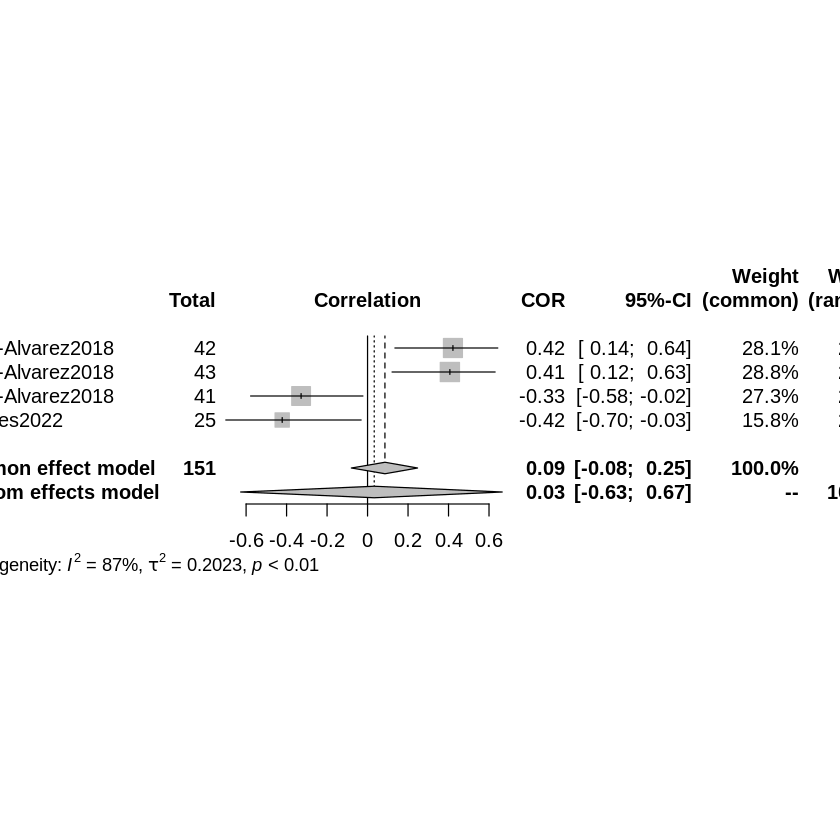

In [18]:
### ### META-ANALYSYS CODE ##################

#First, we need to calculate coefficients of correlation



#load packages-Don't think we need all this packages, but i don't remember
#what particular functions belong to what package 

library (meta)
library (esc)
library (dplyr)

#estimating coefficients of correlation
# names (MetaAnalysis_Data)
#extracting values when there is p-values and t-values
#remove row with Paredes data because statistics value is based on a chisquare
MetaAnalysis_subsetPerez <-MetaAnalysis_Data[-c(4), ] 


#now we can calculate correlations (es column - these values are also called the r values) based on P-values and Sample size 

EffectSizes_Perez<-effect_sizes(MetaAnalysis_subsetPerez, p = p.value, totaln = Sample_size, study = Study, fun = "esc_t", es.type="r")
EffectSizes_Perez

# now we calculate r values for paredes 

MetaAnalysis_subsetParedes <-MetaAnalysis_Data[c(4), ] 
#names(MetaAnalysis_subsetParedes)

#extracting data when there is chi-square values
EffectSizes_Paredes<-effect_sizes(MetaAnalysis_subsetParedes, p = p.value, totaln = Sample_size,
                    study = Study, fun = "chisq", es.type="r")
EffectSizes_Paredes
# removing unnecesary columns from the dataframe
EffectSizes_Paredes2 = subset(EffectSizes_Paredes, select = -c(fishers.z,ci.lo.z,ci.hi.z))

#merge datasets
#names (EffectSizes_Perez)
#names (EffectSizes_Paredes)
CoefficientsCorrelation_Data <-rbind(EffectSizes_Perez, EffectSizes_Paredes2)

#all r values are positive, so we need to create a variable to indicate the direction
#add column with direction and an "es2" column, which is the coefficient of correlation values with the direction attached
direction_metaanalysis <- c(1, 1, -1, -1)
CoefficientsCorrelation_Data["Direction"] <- direction_metaanalysis
#names(CoefficientsCorrelation_Data)
CoefficientsCorrelation_Data2 <- mutate (CoefficientsCorrelation_Data, es2=es*Direction)

# calculate overall effect size 

m.cor <- metacor(cor = es2, 
                 n = sample.size,
                 studlab = study,
                 data = CoefficientsCorrelation_Data2,
                 method.tau = "REML",
                 hakn = TRUE,
                 title = "Mini Meta-analysis")
summary(m.cor)
#interpreting the summary output: We want to focus on the output of the "Random effects model". This is the more conservative model (compared to the fixed effects model) as it considers studies as a random effect (i.e., we expect more variability between observations from different studies than observations within the same study). The COR value is the overall effect size (overall coefficient of correlation). Then you have confidence interval values; when these overlap zero we have a non-significant effect, which here is also confirmed by the p-value. This is the most basic way to run a meta-analysis. If we were working with a real data set we would also, weight the estimated values by sample size or variability, we would also standardize the coefficients of correlation. However, this is not really needed here because this is just a proof-of-concept synthesis to demonstrate how the ORKG can support/facilitate/streamline synthesis research. We are not expecting a meaningful ecological interpretation from the meta-analysis output.


forest(m.cor)
# overall, analysis indicate there is no significant
#correlation between pest abundance/incidence and landscape complexity